In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 288 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 2.1 MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import requests 
import copy
import numpy as np
from IPython.display import display
import yfinance as yf
import pandas_datareader
import math 
from sklearn import preprocessing
import pypfopt 

### Define function

#### Get adjusted price from Yahoo finance

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# year_ago = 1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# interval = 1d,1wk,1mo 
def get_adjusted_price(symbols, interval="1mo",year_ago="5y"):
    sym_string = " ".join(symbols)
    df = yf.download(sym_string,group_by = 'ticker',interval=interval,period=year_ago)
    # extract the second-level (Adj Close) and drop the level with symbol name left
    df = df.xs("Adj Close",axis =1, level=1, drop_level=True)
    
    return (df,df.columns)

#### Risk Premium

In [ ]:
# return MONTHLY risk-free rate 
def get_rf_lst():
     url = 'https://data.nasdaq.com/api/v3/datasets/FRED/DGS5.json?api_key=WSyPTtqy6YG_yeY2Lwb8&start_date=2000-01-01&collapse=monthly'
     rf_data = requests.get(url).json()
     return (pd.DataFrame(rf_data["dataset"]["data"]))[1]/1200

# return current ANNUAL rf
def get_rf():
     return get_rf_lst()[0]*12

# return the return (percent change minus risk-free rate) 
def get_risk_premium(df):
     df=(df.reset_index(drop=True).pct_change()).sub(get_rf_lst()[:len(df)][::-1],axis=0)
     return df

#### Optimization

In [ ]:
from scipy.optimize import minimize, LinearConstraint

def objective_SR (weight,rtn,cov_mat):
     rtn = np.dot(weight,rtn)
     std = np.sqrt(np.matmul(np.matmul(weight,cov_mat),weight))
     sr = (rtn - get_rf())/std
     return -sr # minimize negative Sharpe == maximize sharpe


## OOP time 
### input:  
symbol_list - list of symbols of stocks <br>
interval (default = "1mon") - interval of each data point <br>
year_ago (default = "5y") - time frame of historical data to use <br>
short_sale_constrain (default = True) - true if NOT allow to short sale (no negative weight) <br>
ind_weight_constrain (default = None) - percentage that each weight cannot exceed (cannot exceed 1/N fro N stocks) <br>
invested_cash (default = 100000) - cash you want to indvest in this portfolio

In [ ]:
class portfolio:
    def __init__(self,symbol_list,interval="1mo",year_ago="5y",short_sale_constrain = True, ind_weight_constrain = None, invested_cash = 100000):

        annualize = {"1d":256,"1wk":52,"1mo":12}

        self.price_df,self.symbol_list = get_adjusted_price(symbol_list,interval=interval,year_ago=year_ago)
        self.short_sale_constrain = short_sale_constrain
        self.ind_weight_constrain = ind_weight_constrain
        self.num_stock = len(self.symbol_list)
        self.cov_mat = get_risk_premium(self.price_df).cov() * (annualize[interval]) #SAMPLE?
        self.ann_rtn_mat = get_risk_premium(self.price_df).mean() * (annualize[interval]) +get_rf() # add rf back to get total return
        self.weight_mat = np.ones(self.num_stock)/self.num_stock
        self.sharpe = 0
        self.ann_rtn = 0 
        self.std = 0
        self.invest_cash = invested_cash

    # show stock price time series plot
    def show_price_plot(self):
        self.price_df.plot()

    # print sharpe, return and standard deviation
    def visualize_stat(self):
        print("Sharpe Ratio:",round(self.sharpe,4))
        print("Annul return:",round(self.ann_rtn,4)*100,"%")
        print("Standard deviation:", round(self.std,4)*100,"%")

    # calculate num of stocks to buy
    def num_stock_to_buy(self,current_price,equal=False):
        if equal:
          equal_weight = (np.ones(self.num_stock)/self.num_stock)
          return ( equal_weight * self.invest_cash/ current_price).astype(int).rename(index=lambda x:"number of stock")
        else:
          return (self.weight_mat * self.invest_cash/ current_price).astype(int).rename(index=lambda x:"number of stock")

  
    def max_SR(self):

        # the max weight range is from -300% to 300% if there is no constraint

        # ind weight constraint
        upper = (self.ind_weight_constrain) if (self.ind_weight_constrain) else 3
        # short sale constrain
        lower = 0 if self.short_sale_constrain else -3

        bound = [(lower,upper)] * self.num_stock
        #sum of weight should be 1
        con = LinearConstraint(np.ones(self.num_stock), lb=1, ub=1)

        # minimize neg Sharpe = max Sharpe
        result = minimize(objective_SR,x0=self.weight_mat,args=(self.ann_rtn_mat,self.cov_mat),bounds=bound,constraints=con)

        # update stat 
        self.sharpe = -(result["fun"])
        self.weight_mat = result["x"]
        self.ann_rtn = np.dot(self.weight_mat,self.ann_rtn_mat)
        self.std = np.sqrt(np.matmul(np.matmul(self.weight_mat,self.cov_mat),self.weight_mat))

        # visualize stat
        self.visualize_stat()

        # visualize weight table 
        display_df = pd.DataFrame({" ":self.symbol_list,"Weight":list(map(lambda x:str(round(x,3)*100)+"%", self.weight_mat))})
        display_df = display_df.transpose()
        display_df.columns = display_df.iloc[0]
        display_df=display_df.iloc[1:,:]
        display_df = pd.concat([display_df,self.num_stock_to_buy(self.price_df[-1:])])
        display(display_df)
      
    def Black_Litterman_model(self,view):

        spy=yf.download("SPY")["Adj Close"]
        # risk aversion score on SPY (index)
        risk_aversion = pypfopt.black_litterman.market_implied_risk_aversion(spy, risk_free_rate=get_rf())
        # Black_Litterman Model
        bl=pypfopt.BlackLittermanModel(cov_matrix=client1.cov_mat, pi=client1.ann_rtn_mat,absolute_views=view,risk_aversion=risk_aversion)

        # update stat
        # we use POSTERIOR return & cov that are based on prior return to calculate portfolio stat
        self.symbol_list = list(bl.bl_weights().keys())
        self.weight_mat = np.array(list(bl.bl_weights().values()))
        self.ann_rtn = np.dot(list(bl.bl_weights().values()),bl.bl_returns()) + get_rf() # model output EXCESS return --> add rf back
        self.std = np.sqrt(np.matmul(np.matmul(self.weight_mat,bl.bl_cov()),self.weight_mat))
        self.sharpe = (self.ann_rtn- + get_rf())/ self.std

        # visualize stat
        self.visualize_stat()

        # Visualization
        display_df = pd.DataFrame.from_dict(bl.bl_weights(),orient="index")
        display_df.columns=["Weight"]
        display_df["Weight"] = display_df["Weight"].apply(lambda x : str(round(x,3)*100)+"%")
        display_df = display_df.transpose()
        display_df = pd.concat([display_df,self.num_stock_to_buy(self.price_df[-1:])])
        display(display_df)

    def back_test(self):
      # daily price
      daily_price,sym = get_adjusted_price(self.symbol_list,interval="1d",year_ago="5y")
      # spy
      spy = yf.download("SPY",interval="1d",period="5y")["Adj Close"]

      price_len = len(daily_price)
      # splice total stock data into 1 and 3 years 
      three_yr = daily_price.iloc[price_len-255*3:][self.symbol_list]
      three_yr_spy= spy[price_len-255*3:]
      one_yr = daily_price.iloc[price_len-255:][self.symbol_list]
      one_yr_spy= spy[price_len-255:]

      # calculate the starting porfolio and the trend 
      three_yr_start = three_yr.iloc[0]

      three_yr_port = self.num_stock_to_buy(three_yr_start)
      three_yr_num_sp = int(self.invest_cash/three_yr_spy[0])
      three_yr_equal = self.num_stock_to_buy(three_yr_start,equal=True)
      
      port_trend = np.sum(three_yr * list(three_yr_port),axis=1)
      spy_trend = three_yr_spy * three_yr_num_sp
      equal_trend = np.sum(three_yr * list(three_yr_equal),axis=1)
      plt.plot(port_trend,label="Portfolio")
      plt.plot(spy_trend,label="SPY")
      plt.plot(equal_trend,label="Equal Weighted")
      plt.title("Three-year trend SPY vs Porfolio vs Equal Weight")
      plt.axhline(self.invest_cash,linestyle = '--')
      plt.legend()
      plt.show()
      # calculate the starting porfolio and the trend 
      one_yr_start = one_yr.iloc[0]

      one_yr_port = self.num_stock_to_buy(one_yr_start)
      one_yr_equal = self.num_stock_to_buy(one_yr_start,equal=True)
      one_yr_num_sp = int(self.invest_cash/one_yr_spy[0])

      port_trend = np.sum(one_yr * list(one_yr_port),axis=1)
      spy_trend = one_yr_spy * one_yr_num_sp
      equal_trend = np.sum(one_yr * list(one_yr_equal),axis=1)
      plt.plot(port_trend,label="Portfolio")
      plt.plot(spy_trend,label="SPY")
      plt.plot(equal_trend,label="Equal Weighted")
      plt.title("One-year trend SPY vs Porfolio vs Equal Weight")
      
      plt.legend()
      plt.axhline(self.invest_cash,linestyle = '--')
      plt.show()

# Initialize Your Portfolio Here 
year_ago = 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max </br>
short_sale_constrain = True, False </br>
ind_weight_constrain should be larger than 1/N (otherwise get total weight not =1) </br>
input will be limited in frontend


In [ ]:
client1= portfolio(["AAPL","IBM","GOOGL","META"],year_ago="5y",short_sale_constrain = False, ind_weight_constrain = None)

[*********************100%***********************]  4 of 4 completed


### Visualize price

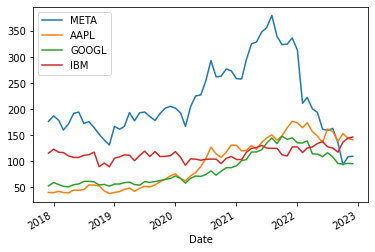

In [ ]:
client1.show_price_plot()

## Max Sharpe (purely based on historical data)

In [ ]:
client1.max_SR()

Sharpe Ratio: 1.1282
Annul return: 45.35 %
Standard deviation: 37.49 %


,META,AAPL,GOOGL,IBM
Weight,-73.8%,110.5%,54.1%,9.2%
number of stock,-674,782,568,62


## Black-Litterman model (adding user's view) </br>
The model is currently using historical return as prior return. I will implement IMPLIED prior return from the market cap weight in given index, such as S&P 500 in this case, which gives us more forward-looking return in the model. Black_Litterman model is more like a linear algebra solution than optimization solution. Thus, I did not find a good way to put constraint (ex. short sale constraint) rather than controlling user's weight. 

In [ ]:
view = {"AAPL":-0.2,"META":0.2,"GOOGL":-0.05,"IBM":0}

In [ ]:
client1.Black_Litterman_model(view)

[*********************100%***********************]  1 of 1 completed
Sharpe Ratio: 0.2995
Annul return: 13.819999999999999 %
Standard deviation: 35.96 %


,META,AAPL,GOOGL,IBM
Weight,-79.7%,91.9%,62.8%,25.0%
number of stock,-728,651,659,170


[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


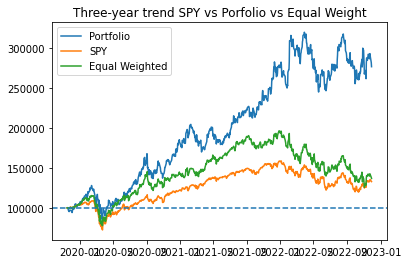

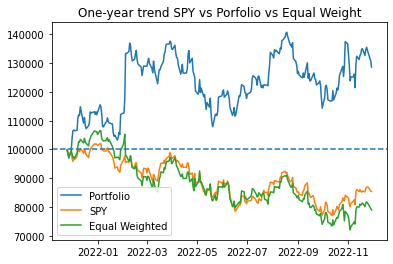

In [ ]:
client1.back_test()

## LSTM on daily price
### Input the stock you want to predict

In [ ]:
stock_to_predict = "AAPL"

In [ ]:
stock_df =yf.download(stock_to_predict,period="5y")

[*********************100%***********************]  1 of 1 completed


## Preprocess data for LSTM
### preprocess function
For each data point t = i, </br>
   x is close price & volume from (i-day_ago) ~ (i-1) </br>
   y is close price at i

In [ ]:
def preprocess_ds(data,day_ago):
     x = []
     y = []
     for i in range(day_ago,len(data)):
          x.append(data[i-day_ago:i]) # historical data: (i-day_ago)~(i-1)
          y.append(data[i,0]) # current observation: i
     return (np.array(x),np.array(y))

### Normalization & train-test split

In [ ]:
day_ago = 50
feature_lst = ["Close","Volume"]
num_feature = len(feature_lst)

# Normalization 
feature_normalizer = preprocessing.MinMaxScaler()
normalized_df = feature_normalizer.fit_transform(stock_df[feature_lst])
target_normalizer = preprocessing.MinMaxScaler() # use this to transfer prediction back 
target_normalizer.fit(stock_df[["Close"]]) 

# train-test split
train_split = 0.8
split_pt = math.ceil(len(normalized_df) * train_split)

train_set = normalized_df[:split_pt]
test_set = normalized_df[split_pt:]

train_x , train_y = preprocess_ds(train_set,day_ago=day_ago)
test_x, test_y = preprocess_ds(test_set,day_ago=day_ago)

## model building 

In [ ]:
from tensorflow.python import metrics
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

keras.backend.clear_session()

model = keras.Sequential()
model.add(layers.LSTM(150,input_shape=(day_ago,num_feature),return_sequences=True))
model.add(layers.LSTM(100))
model.add(layers.Dense(30,activation="relu"))
model.add(layers.Dense(1))

model.compile(loss="mean_squared_error",
          optimizer="adam")

## Fit model on train set


In [ ]:
batch_size = 1
epochs = 5
# Train with train set

model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size)

Epoch 1/5
957/957 [==============================] - 43s 41ms/step - loss: 0.0024
Epoch 2/5
957/957 [==============================] - 38s 40ms/step - loss: 0.0011
Epoch 3/5
957/957 [==============================] - 39s 41ms/step - loss: 7.9080e-04
Epoch 4/5
957/957 [==============================] - 39s 40ms/step - loss: 7.0712e-04
Epoch 5/5
957/957 [==============================] - 40s 42ms/step - loss: 6.1179e-04


### Predict on test set

In [ ]:
pred_y = model.predict(test_x)

7/7 [==============================] - 1s 43ms/step


## Visualization of test set

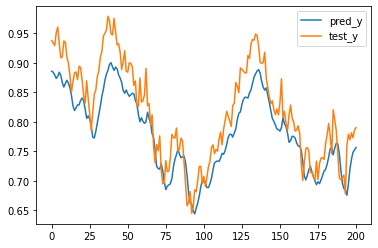

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pred_y,label="pred_y")
plt.plot(test_y,label="test_y")
plt.legend()